# Compare to Single Velocity Model
Assess how well our model trained on separate velocities compares to our previous models trained on only a single velocity

In [2]:
%matplotlib inline
from matplotlib import pyplot as plt
import os
import sys
sys.path.append(f"{os.getcwd()}/../")
from stopping_power_ml.integrator import TrajectoryIntegrator
from sklearn.metrics import mean_absolute_error
from scipy.stats import spearmanr
import pickle as pkl
import pandas as pd
import numpy as np
import keras

2024-06-17 12:40:18.101068: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-17 12:40:18.101658: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-17 12:40:18.959112: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-17 12:40:20.278316: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 AVX512_FP16 AVX_VNNI AMX_TILE AMX_INT8 AMX_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-17 12:40:32.901250

## Load in the Model and Featurizer
The model is saved in Keras h5, and the featurizer is in the root directory

In [3]:
model = keras.models.load_model('model.h5')

2024-06-17 12:40:45.811871: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:282] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2024-06-17 12:40:45.811914: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:134] retrieving CUDA diagnostic information for host: ccc0422.campuscluster.illinois.edu
2024-06-17 12:40:45.811921: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:141] hostname: ccc0422.campuscluster.illinois.edu
2024-06-17 12:40:45.811996: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:165] libcuda reported version is: 550.54.14
2024-06-17 12:40:45.812024: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:169] kernel reported version is: NOT_FOUND: could not find kernel module information in driver version file contents: "NVRM version: NVIDIA UNIX Open Kernel Module for x86_64  550.54.14  Release Build  (dvs-builder@U16-A24-2-2)  Thu Feb 22 01:44:50 UTC 2024
GCC versi

In [4]:
with open('featurizer.pkl', 'rb') as fp:
    featurizers = pkl.load(fp)

In [5]:
start_frame = pkl.load(open(os.path.join('..', 'al_starting_frame.pkl'), 'rb'))

In [6]:
train_data = pd.concat([
    pd.read_pickle(os.path.join('data', 'random_traj.pkl')),
    pd.read_pickle(os.path.join('data', 'channel_traj.pkl'))
], sort=False)

In [7]:
with open(os.path.join('..', 'single-velocity', 'traj_computer.pkl'), 'rb') as fp:
    traj_int_single = pkl.load(fp)

FileNotFoundError: [Errno 2] No such file or directory: '../single-velocity/traj_computer.pkl'

In [8]:
data = pd.read_pickle(os.path.join('..', 'training_data.pkl.gz'))

## Retrain on Both Channel and Random
This will give us a direct comparison to the single velocity model. The weights will start from the weights learned from the random trajectory.

In [9]:
model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])

In [10]:
callbacks = [keras.callbacks.EarlyStopping(monitor='mean_absolute_error', patience=100, verbose=0, mode='auto'),
             keras.callbacks.ReduceLROnPlateau('mean_absolute_error', min_delta=1e-6)]

In [11]:
%%time
history = model.fit(train_data[featurizers.feature_labels()], train_data['force'], callbacks=callbacks, verbose=0, epochs=1000)

CPU times: user 11min 38s, sys: 15.9 s, total: 11min 54s
Wall time: 19min 30s


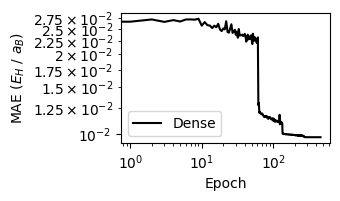

In [12]:
fig, ax = plt.subplots()

ax.loglog(history.epoch, history.history['mean_absolute_error'], 'k', label='Dense')

ax.set_ylabel('MAE ($E_H$ / $a_B$)')
ax.set_xlabel('Epoch')

ax.legend()

fig.set_size_inches(3.5, 2.1)
fig.tight_layout()

*Finding*: It does converge in a few hundred epochs

Save for later use

In [13]:
model.save('model-random-and-channel.h5')

## Get Trajectory Integration Tools
These black box the annoying parts of making the trajectories. We'll re-use the one for single velocities (imported earlier)

In [14]:
traj_int = TrajectoryIntegrator(start_frame, model, featurizers)

## Plot the Performance on $v=1.0$ Trajectories
This is the trajectories for which we have the most data

In [15]:
v1_data = data[np.isclose(data['velocity_mag'], 1.0, atol=1e-3)]

NameError: name 'traj_int_single' is not defined

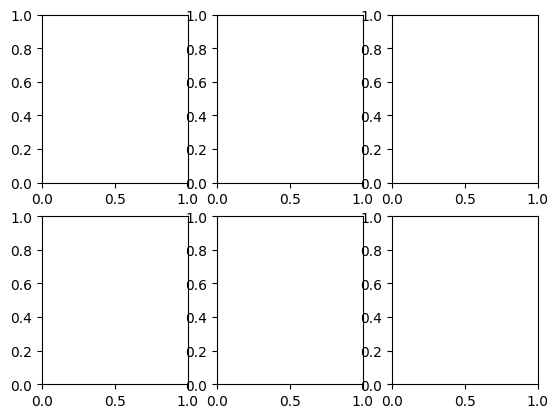

In [16]:
fig, axs = plt.subplots(2, 3)
axs = axs.flatten()

acc_scores = []

for i, (ax, (d, subset)) in enumerate(zip(axs, v1_data.groupby('directory'))):
    subset = subset.query('displacement > 6')
    
    # Get the values
    single_pred = traj_int_single.model.predict(subset[traj_int_single.featurizers.feature_labels()])
    multi_pred = traj_int.model.predict(subset[traj_int.featurizers.feature_labels()])
    
    # Plot them
    ax.plot(subset['displacement'], subset['force'], 'k--')
    ax.plot(subset['displacement'], single_pred, 'r', lw=1, alpha=0.8)
    ax.plot(subset['displacement'], multi_pred, 'b', lw=1, alpha=0.8)
    
    if subset['force'].max() > 1:
        ax.set_yscale('symlog')
    
    # Make a label for the figure
    ax.text(0, 1, os.path.basename(d), bbox={'facecolor': 'w', 'edgecolor': 'k'},
           transform=ax.transAxes)
    
    # Make axes labels
    if i >= 3:
        ax.set_xlabel('Displacement')
    if i % 3 == 0:
        ax.set_ylabel('Force ($E_H / a_B$)')
        
    # Measure the accuracy
    acc_scores.append({
        'subset': d,
        'mae_single': mean_absolute_error(subset['force'], single_pred),
        'mae_multi': mean_absolute_error(subset['force'], multi_pred),
        'spearman_single': spearmanr(subset['force'], single_pred)[0],
        'spearman_multi': spearmanr(subset['force'], multi_pred)[0],
        'stopping': subset['force'].mean(),
        'stopping_single': single_pred.mean(),
        'stopping_multi': multi_pred.mean(),
    })
        
            
fig.tight_layout()
fig.set_size_inches(6.5, 3.5)
fig.savefig(os.path.join('figures', 'validation-set.png'), dpi=320)

*Finding*: They look pretty similar

### Compare the Scores Quantitatively
See if the models just "appear better"

In [17]:
acc_scores = pd.DataFrame(acc_scores)

In [18]:
acc_scores

""


#### Compare Fitness to Forces
This is one metric of success

KeyError: 'spearman_single'

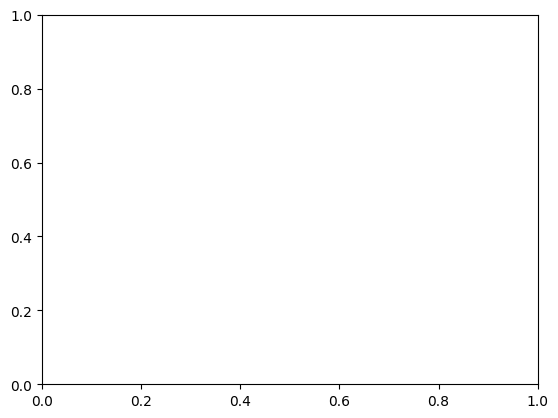

In [19]:
fig, ax = plt.subplots()

ax.scatter(acc_scores['spearman_single'], acc_scores['spearman_multi'])

ax.set_xlim(ax.get_xlim())
ax.set_ylim(ax.get_xlim())

ax.plot(ax.get_xlim(), ax.get_ylim(), 'k--')

ax.set_xlabel('Spearman, Single')
ax.set_ylabel('Spearman, Mutli')

fig.set_size_inches(3.5, 3.5)

*Finding*: The Spearman correlation coefficient for the multi-velocity model is generally better.

### Compare Stopping Powers
Which gives a better stopping power prediction

In [20]:
print('Multi-Velocity MAE: {:.3e} E_H/a_B'.format(mean_absolute_error(acc_scores['stopping'], acc_scores['stopping_multi'])))
print('Multi-Velocity MAE: {:.2f}%'.format(100 * np.mean(np.abs(acc_scores['stopping'] - acc_scores['stopping_multi']) / acc_scores['stopping'])))

KeyError: 'stopping'

In [21]:
print('Single-Velocity MAE: {:.3e} E_H/a_B'.format(mean_absolute_error(acc_scores['stopping'], acc_scores['stopping_single'])))
print('Single-Velocity MAE: {:.2f}%'.format(100 * np.mean(np.abs(acc_scores['stopping'] - acc_scores['stopping_single']) / acc_scores['stopping'])))

KeyError: 'stopping'

KeyError: 'stopping'

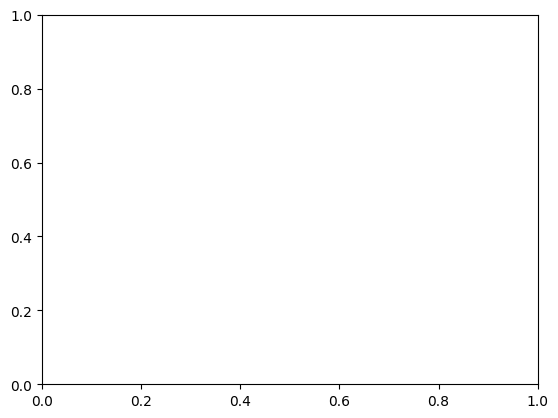

In [22]:
fig, ax = plt.subplots()

ax.scatter(acc_scores['stopping'], acc_scores['stopping_multi'], label='Multi', alpha=0.7)
ax.scatter(acc_scores['stopping'], acc_scores['stopping_single'], label='Single', alpha=0.7)

ax.set_ylim(ax.get_xlim())
ax.set_xlim(ax.get_ylim())

ax.plot(ax.get_xlim(), ax.get_ylim(), 'k--')

ax.set_xlabel('S, TD-DFT ($E_H/a_B$)')
ax.set_ylabel('S, ML ($E_H/a_B$)')

fig.set_size_inches(3.5, 3.5)
fig.tight_layout()

*Finding*: The multi-velocity model has *slightly* better stopping power predictions.